In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
import pandas as pd

from definitions import ROOT_DIR
from unc.utils import load_info

plt.rcParams.update({'font.size': 18})

In [13]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


all_paths = {
'2': Path(ROOT_DIR, 'results', '2_actor_critic'),
'2o':  Path(ROOT_DIR, 'results', '2o_actor_critic'),
'2pb': Path(ROOT_DIR, 'results', '2pb_actor_critic'),
'2d': Path(ROOT_DIR, 'results', '2d_actor_critic')
}

plot_info = {
    '2': {
        'color': '#16a085', 
        'label': {'x': 1.5e5, 'y': 13.2, 'text': 'Observations'}
    },
    
    '2o': {
        'color': '#d35400',       
        'label': {'x': 0.75e5, 'y': 14.0, 'text': 'Trace'}
    },
    '2pb': {
        'color': '#34495e', 
        'label': {'x': 0.2e5, 'y': 13.8, 'text': 'PF'}
    },
    '2d': {
        'color': '#8e44ad', 
        'label': {'x': 0.4e5, 'y': 14.1, 'text': 'Likelihood'}
    },

}

split_by = ['env', 'step_size', 'algo', 'arch', 'n_hidden']
Args = namedtuple('args', split_by)

plot_path = Path()


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [14]:
def process_dir(dir_path, split_by):
    all_results = {}
        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue

        info = load_info(f)
        args = info['args'].item()

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

#         all_results[hparams].append((info['episode_reward'], args))
        all_results[hparams].append((args, info['episode_reward'], f))


    
    return all_results

In [22]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    
    raw_data[key] = {}
    for hparams, ret in processed.items():
        rew_lst, arg_lst, f_lst = [], [], []
        for r in ret:
            rew_lst.append(r[1])
            arg_lst.append(r[0])
            f_lst.append(r[2])
            rews =
        raw_data[key][hparams] = {'rewards': np.stack(rew_lst)[:, :, 'args': arg_lst, 'paths': f_lst}
        print(raw_data[key][hparams]['rewards'].shape)

  0%|          | 0/101 [00:00<?, ?it/s]

(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)


  0%|          | 0/101 [00:00<?, ?it/s]

(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)


  0%|          | 0/101 [00:00<?, ?it/s]

(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)


  0%|          | 0/101 [00:00<?, ?it/s]

(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)
(10, 2500)


In [19]:
# Here we get our best hparams
all_best = {}
for key, res in raw_data.items():
    stats_list = []
    for args, rew_dict in res.items():
        # we take mean over both time and seeds
        stats_list.append((args, rew_dict['rewards'].mean(), rew_dict['rewards'], rew_dict['args'], rew_dict['paths']))
    all_best[key] = sorted(stats_list, key=lambda x: x[1])[-1]
for k, v in all_best.items():
    print(k, v[0], v[1])

2 args(env='2', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10) 16.91752
2o args(env='2o', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10) 17.97028
2pb args(env='2pb', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10) 17.33608
2d args(env='2d', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10) 17.85028


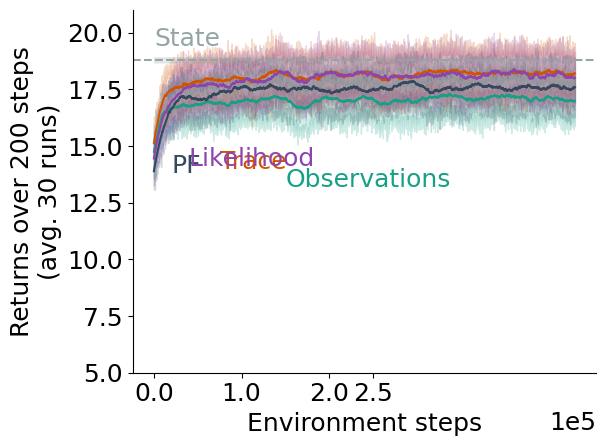

In [20]:
steps_per_eps = 200
plotting_order = ['2', '2o', '2pb', '2d']
lobster_results_path = Path(ROOT_DIR, 'results', f'all_lobster_ppo_results.pdf')
fig, ax = plt.figure(), plt.axes()


for k in plotting_order:
    v = all_best[k]
#     if k not in selection:
#         continue
    data = v[2]
    key = plot_info[k]['label']['text']
    color = plot_info[k]['color']

    means = moving_avg(data.mean(axis=0), w=100, mode='valid')
    x = np.arange(means.shape[0]) * steps_per_eps

    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err[:means.shape[0]], means + std_err[:means.shape[0]],
                         color=color, alpha=0.2)
    l_info = plot_info[k]['label']
    plt.text(l_info['x'], l_info['y'], l_info['text'], color=color, fontdict=dict(size=18))

ax.set_ylim(5, 21)

ax.axhline(18.8, linestyle='--', color='#95a5a6')
plt.fill_between(x, 18.8 + 0.112, 18.8 - 0.112, color='#95a5a6', alpha=0.2)
plt.text(0e5, 19.4, 'State', color='#95a5a6', fontdict=dict(size=18))


ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns over 200 steps\n(avg. 30 runs)")
ax.set_xticks([0, 1e5, 2e5, 2.5e5])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
# ax.set_title(f'Lobster Environment')


# plt.savefig(lobster_results_path, bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')